<a href="https://colab.research.google.com/github/pjcroxas/Forecasting/blob/main/Seat_Capacity_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Owner: *Patrick Jose C. Roxas*

In [2]:
# Import necessary libraries
from google.colab import auth
auth.authenticate_user()
import random
import gspread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [3]:
# Read google sheet data
worksheet = gc.open('Seat capacity forecasting').sheet1
actual_data = gc.open('Actual Data').sheet1
cell_list = worksheet.range('A1:D31')
cell_list_actual = actual_data.range('A1:F11')

rows = worksheet.get_all_values()
rows_b = actual_data.get_all_values()

In [4]:
# Import the row data to pandas library
import pandas as pd
df = pd.DataFrame.from_records(rows[1:], columns=['Game', 'Year', 'Opponent Team', 'Attendees'])
df.head()

,Game,Year,Opponent Team,Attendees
0,1,2015,Baylor,34200
1,2a,2015,Texas,39800
2,3,2015,LSU,38200
3,4b,2015,Arkansas,26900
4,5,2015,USC,35100


In [5]:
# Check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Game           30 non-null     object
 1   Year           30 non-null     object
 2   Opponent Team  30 non-null     object
 3   Attendees      30 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB


In [6]:
# pre-processing
df['Attendees'] = df['Attendees'].astype(int)
df['Year'] = pd.to_datetime(df.Year, format='%Y')
df['Year_'] = df['Year'].dt.year

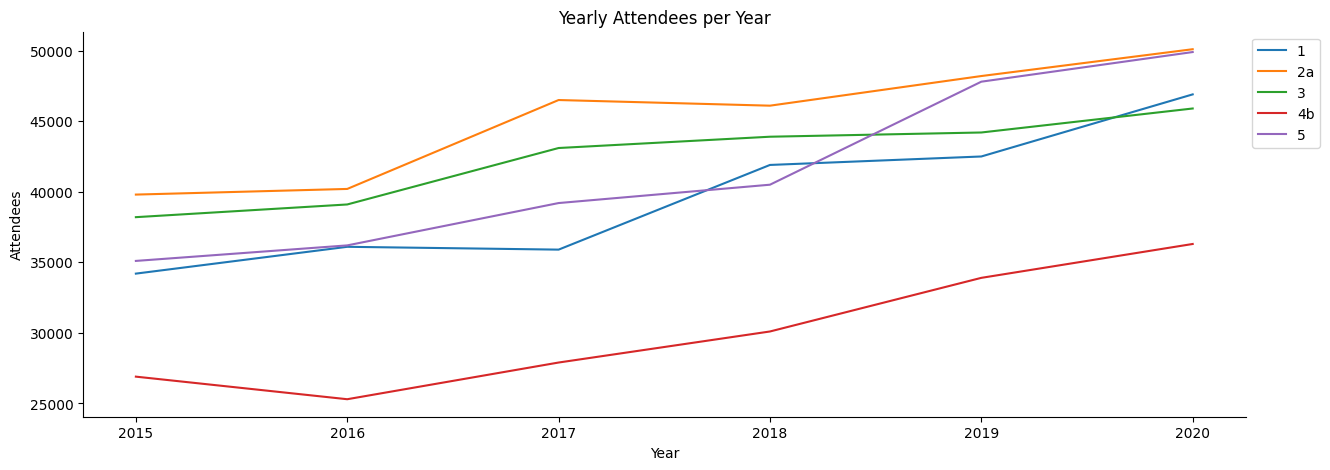

In [12]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(df,
                  x="Year_",
                  y="Attendees",
                  hue='Game')
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("Year")
plt.title("Yearly Attendees per Year")
ax.legend(bbox_to_anchor=(1, 1))

In this plot, we can generalize that there is a yearly increase among the attendees at SWU. It can be also observed the difference of attendees per game.

- From 2015-2020,
  - (1) game 2a always has the leading number of attendees (homecoming games).
  - (2) game 4b always has the least number of attendees (due to festival).

We can say that game number and year plays a large factor in determining the attendees.


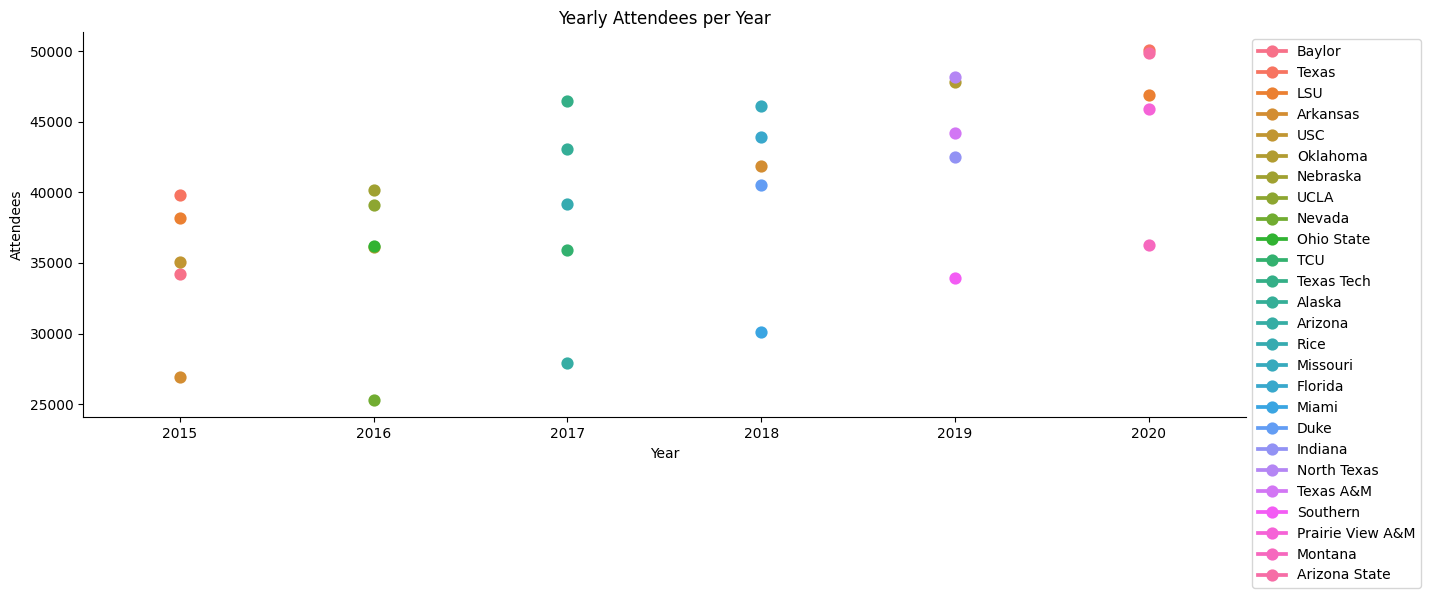

In [15]:
plt.figure(figsize=(15, 5))
ax = sns.pointplot(df,
                  x="Year_",
                  y="Attendees",
                  hue='Opponent Team')
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("Year")
plt.title("Yearly Attendees per Year")
ax.legend(bbox_to_anchor=(1, 1))

In this graph, we can say that 'opponent team' has only a slight factor in determining the number of attendees. Why? from 2015 to 2020 most of the opponent team are not repeating, so we don't have any baseline. Only a handful of 4 games are repeating, and we don't have any data which here are the winner.

Since we can't established a solid causality in between the attendees and opponent team, I excluded this data in our modeling part.

## **Modeling: Multiple Linear Regression**

In [16]:
# Converting categorical data to numerical
games_df = pd.get_dummies(df, columns=['Game'])
games_df.head()

,Year,Opponent Team,Attendees,Year_,Game_1,Game_2a,Game_3,Game_4b,Game_5
0,2015-01-01,Baylor,34200,2015,True,False,False,False,False
1,2015-01-01,Texas,39800,2015,False,True,False,False,False
2,2015-01-01,LSU,38200,2015,False,False,True,False,False
3,2015-01-01,Arkansas,26900,2015,False,False,False,True,False
4,2015-01-01,USC,35100,2015,False,False,False,False,True


In [17]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Year           30 non-null     datetime64[ns]
 1   Opponent Team  30 non-null     object        
 2   Attendees      30 non-null     int64         
 3   Year_          30 non-null     int32         
 4   Game_1         30 non-null     bool          
 5   Game_2a        30 non-null     bool          
 6   Game_3         30 non-null     bool          
 7   Game_4b        30 non-null     bool          
 8   Game_5         30 non-null     bool          
dtypes: bool(5), datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 1.1+ KB


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [19]:
# Splitting the data
X = games_df[['Year_', 'Game_1', 'Game_2a', 'Game_3', 'Game_4b', 'Game_5']]
y = games_df['Attendees']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [20]:
# Training the model
model = LinearRegression()
model.fit(X_train, y_train)
test_forecast = model.predict(X_test)

In [21]:
# Measuring error
from sklearn.metrics import mean_absolute_error, r2_score
print('MAE: ', mean_absolute_error(y_test, test_forecast))
print('r2: ',r2_score(y_test, test_forecast))

MAE:  1414.6816198527813
r2:  0.9367238913756183


### **Forecast**

In [22]:
actual_df = pd.DataFrame.from_records(rows_b[1:], columns=['Year', 'Game_1', 'Game_2a', 'Game_3', 'Game_4b', 'Game_5'])
actual_df['Year'] = pd.to_datetime(actual_df.Year, format='%Y')
actual_df['Year_'] = actual_df['Year'].dt.year

actual_df['Game_1'] = actual_df['Game_1'].astype(int)
actual_df['Game_2a'] = actual_df['Game_2a'].astype(int)
actual_df['Game_3'] = actual_df['Game_3'].astype(int)
actual_df['Game_4b'] = actual_df['Game_4b'].astype(int)
actual_df['Game_5'] = actual_df['Game_5'].astype(int)
actual_df.head()

,Year,Game_1,Game_2a,Game_3,Game_4b,Game_5,Year_
0,2021-01-01,1,0,0,0,0,2021
1,2021-01-01,0,1,0,0,0,2021
2,2021-01-01,0,0,1,0,0,2021
3,2021-01-01,0,0,0,1,0,2021
4,2021-01-01,0,0,0,0,1,2021


In [23]:
actual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Year     10 non-null     datetime64[ns]
 1   Game_1   10 non-null     int64         
 2   Game_2a  10 non-null     int64         
 3   Game_3   10 non-null     int64         
 4   Game_4b  10 non-null     int64         
 5   Game_5   10 non-null     int64         
 6   Year_    10 non-null     int32         
dtypes: datetime64[ns](1), int32(1), int64(5)
memory usage: 648.0 bytes


In [24]:
def predict_capacity(year, dataset, model=model):
  year_data = dataset[dataset['Year_'] == year][['Year_', 'Game_1', 'Game_2a',
                                                    'Game_3', 'Game_4b', 'Game_5']]
  forecast_data = model.predict(year_data)
  year_data['Estimated Attendees'] = forecast_data
  year_data['Estimated Attendees'] = year_data['Estimated Attendees'].astype(int)
  year_data['Estimated Revenue ($)'] = year_data['Estimated Attendees'] * 50
  year_data['Estimated Revenue ($)'] = year_data['Estimated Revenue ($)'].map('{:,}'.format)
  return year_data

In [ ]:
predict_capacity(2021, actual_df)

,Year_,Game_1,Game_2a,Game_3,Game_4b,Game_5,Estimated Attendees,Estimated Revenue ($)
0,2021,1,0,0,0,0,47178,"2,358,900"
1,2021,0,1,0,0,0,52984,"2,649,200"
2,2021,0,0,1,0,0,50663,"2,533,150"
3,2021,0,0,0,1,0,38000,"1,900,000"
4,2021,0,0,0,0,1,49009,"2,450,450"


In [25]:
predict_capacity(2022, actual_df)

,Year_,Game_1,Game_2a,Game_3,Game_4b,Game_5,Estimated Attendees,Estimated Revenue ($)
5,2022,1,0,0,0,0,49417,"2,470,850"
6,2022,0,1,0,0,0,55223,"2,761,150"
7,2022,0,0,1,0,0,52902,"2,645,100"
8,2022,0,0,0,1,0,40238,"2,011,900"
9,2022,0,0,0,0,1,51248,"2,562,400"
